In [192]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

## Configure devices

In [193]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [194]:
random_seed = 42

torch.use_deterministic_algorithms(True)
torch.manual_seed(random_seed)

## Load Dataset

In [195]:
base_train_df = pd.read_csv('./data/train_data.csv')
base_test_df = pd.read_csv('./data/test_data.csv')

base_train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Data Preprocessing

In [196]:
def index_encode(df: pd.DataFrame, column: str, mappings: dict = None) -> tuple[pd.DataFrame, dict]:
    if not column in df.columns or df[column].dtype != 'object':
        return df, {}
    
    unique_values = df[column].unique()
    if mappings is not None:
        unique_values = [value for value in unique_values]
        missings = [value for value in unique_values if value not in mappings]
        if len(missings) > 0:
            raise ValueError(f"Missing values in mappings: {missings}")
    else:
        mappings = {value: index for index, value in enumerate(unique_values)}

    encoded_df = df.copy()
    encoded_df[column] = encoded_df[column].map(mappings)

    return encoded_df, mappings

def one_hot_encode(df: pd.DataFrame, column: str) -> pd.DataFrame:
    if not column in df.columns:
        return df

    cols = pd.get_dummies(df[column], prefix=column)

    encoded_df = pd.concat([df, cols], axis=1)
    encoded_df.drop(column, axis=1, inplace=True)

    return encoded_df

In [197]:
base_train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


### Categorical data

In [198]:
train_df = base_train_df.copy()
test_df = base_test_df.copy()

#### HallwayType

In [199]:
base_train_df["HallwayType"].unique()

array(['terraced', 'corridor', 'mixed'], dtype=object)

In [200]:
hallway_type_mappings = {
    "terraced": 0,
    "mixed": 1,
    "corridor": 2
}

train_df, _ = index_encode(train_df, "HallwayType", hallway_type_mappings)
test_df, _ = index_encode(test_df, "HallwayType", hallway_type_mappings)

print("unique values:", train_df["HallwayType"].unique())
train_df.head()

unique values: [0 2 1]


,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,0,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,2,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,2,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,0,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,1,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


#### HeatingType

In [201]:
base_train_df["HeatingType"].unique()

array(['individual_heating', 'central_heating'], dtype=object)

In [202]:
heating_type_mappings = {
    "central_heating": 0,
    "individual_heating": 1,
}

train_df, _ = index_encode(train_df, "HeatingType", heating_type_mappings)
test_df, _ = index_encode(test_df, "HeatingType", heating_type_mappings)

print("unique values:", train_df["HeatingType"].unique())
train_df.head()

unique values: [1 0]


,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,0,1,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,2,1,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,2,1,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,0,1,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,1,1,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


#### AptManageType

In [203]:
base_train_df["AptManageType"].unique()

array(['management_in_trust', 'self_management'], dtype=object)

In [204]:
apt_manage_type_mappings = {
    "self_management": 0,
    "management_in_trust": 1,
}

train_df, _ = index_encode(train_df, "AptManageType", apt_manage_type_mappings)
test_df, _ = index_encode(test_df, "AptManageType", apt_manage_type_mappings)

print("unique values:", train_df["AptManageType"].unique())
train_df.head()

unique values: [1 0]


,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,0,1,1,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,2,1,0,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,2,1,0,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,0,1,1,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,1,1,0,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


#### TimeToBusStop

In [205]:
base_train_df["TimeToBusStop"].unique()

array(['5min~10min', '0~5min', '10min~15min'], dtype=object)

In [206]:
time_to_bus_stop_mappings = {
    "10min~15min": 0,
    "5min~10min": 1,
    "0~5min": 2
}

train_df, _ = index_encode(train_df, "TimeToBusStop", time_to_bus_stop_mappings)
test_df, _ = index_encode(test_df, "TimeToBusStop", time_to_bus_stop_mappings)

print("unique values:", train_df["TimeToBusStop"].unique())
train_df.head()

unique values: [1 2 0]


,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,0,1,1,111.0,184.0,1,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,2,1,0,80.0,76.0,2,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,2,1,0,80.0,76.0,2,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,0,1,1,249.0,536.0,2,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,1,1,0,142.0,79.0,1,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


#### TimeToSubway

In [207]:
base_train_df["TimeToSubway"].unique()

array(['10min~15min', '5min~10min', '0-5min', '15min~20min',
       'no_bus_stop_nearby'], dtype=object)

In [208]:
time_to_subway_mappings = {
    "no_bus_stop_nearby": 0,
    "15min~20min": 1,
    "10min~15min": 2,
    "5min~10min": 3,
    "0-5min": 4
}

train_df, _ = index_encode(train_df, "TimeToSubway", time_to_subway_mappings)
test_df, _ = index_encode(test_df, "TimeToSubway", time_to_subway_mappings)

print("unique values:", train_df["TimeToSubway"].unique())
train_df.head()

unique values: [2 3 4 1 0]


,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,0,1,1,111.0,184.0,1,2,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,2,1,0,80.0,76.0,2,3,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,2,1,0,80.0,76.0,2,3,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,0,1,1,249.0,536.0,2,4,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,1,1,0,142.0,79.0,1,1,4.0,8.0,Myung-duk,3,9.0,14.0


#### SubwayStation

In [209]:
base_train_df["SubwayStation"].unique()

array(['Kyungbuk_uni_hospital', 'Daegu', 'Sin-nam', 'Myung-duk',
       'Chil-sung-market', 'Bangoge', 'Banwoldang', 'no_subway_nearby'],
      dtype=object)

In [210]:
train_df = one_hot_encode(train_df, "SubwayStation")
test_df = one_hot_encode(train_df, "SubwayStation")

train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,...,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,141592,2006,814,3,0,1,1,111.0,184.0,1,...,6.0,9.0,False,False,False,False,True,False,False,False
1,51327,1985,587,8,2,1,0,80.0,76.0,2,...,12.0,4.0,False,False,False,True,False,False,False,False
2,48672,1985,587,6,2,1,0,80.0,76.0,2,...,12.0,4.0,False,False,False,True,False,False,False,False
3,380530,2006,2056,8,0,1,1,249.0,536.0,2,...,3.0,7.0,False,False,False,False,False,False,True,False
4,78318,1992,644,2,1,1,0,142.0,79.0,1,...,9.0,14.0,False,False,False,False,False,True,False,False


### Data loaders

In [211]:
X_train, y_train = train_df.drop(columns=["SalePrice"]).astype(np.float32), train_df["SalePrice"].astype(np.float32)
X_test, y_test = test_df.drop(columns=["SalePrice"]).astype(np.float32), test_df["SalePrice"].astype(np.float32)

X_train.shape, y_train.shape

((4124, 23), (4124,))

In [212]:
X_train_tensor, y_train_tensor = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor, y_test_tensor = torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [213]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [214]:
batch_size = 256

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)

## Model definition

In [233]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int = 1, dropout: float = 0.2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        x = self.seq(x)
        return x

## Training

In [234]:
criterion = nn.L1Loss()

def train_loop(dataloader, model, optimizer):
    model.train()

    total_loss = 0
    total_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        y = y.view_as(pred)

        loss = criterion(pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss/total_batches


def test_loop(dataloader, model):
    model.eval()

    total_loss = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            y = y.view_as(pred)

            total_loss += criterion(pred, y).item()

    return total_loss/total_batches

In [235]:
def plot_training(train_losses, test_losses):
    import matplotlib.pyplot as plt

    plt.plot(train_losses, label='train')
    plt.plot(test_losses, label='test')
    plt.legend()
    plt.show()

def train_and_evaluate(model, epochs, learning_rate=0.01):
    train_losses = []
    test_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        avg_train_loss = train_loop(train_dl, model, optimizer)
        avg_test_loss = test_loop(test_dl, model)

        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        print(f"Epoch {t+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

    plot_training(train_losses, test_losses)

Epoch 1/500 - Train Loss: 210629.6664 - Test Loss: 187863.5239
Epoch 2/500 - Train Loss: 135399.2872 - Test Loss: 81711.3447
Epoch 3/500 - Train Loss: 76553.1131 - Test Loss: 71525.4940
Epoch 4/500 - Train Loss: 68364.5200 - Test Loss: 66597.0237
Epoch 5/500 - Train Loss: 63524.1317 - Test Loss: 61231.5765
Epoch 6/500 - Train Loss: 58584.8713 - Test Loss: 57585.6167
Epoch 7/500 - Train Loss: 55816.9561 - Test Loss: 54429.0954
Epoch 8/500 - Train Loss: 53442.8022 - Test Loss: 53568.1279
Epoch 9/500 - Train Loss: 52078.9754 - Test Loss: 52412.0355
Epoch 10/500 - Train Loss: 51623.1535 - Test Loss: 52333.4493
Epoch 11/500 - Train Loss: 50584.3114 - Test Loss: 51563.9848
Epoch 12/500 - Train Loss: 49823.2509 - Test Loss: 51395.0173
Epoch 13/500 - Train Loss: 49988.8355 - Test Loss: 51333.4090
Epoch 14/500 - Train Loss: 50262.3194 - Test Loss: 51171.8533
Epoch 15/500 - Train Loss: 50496.6597 - Test Loss: 51076.9314
Epoch 16/500 - Train Loss: 49705.3589 - Test Loss: 50817.2881
Epoch 17/500 -

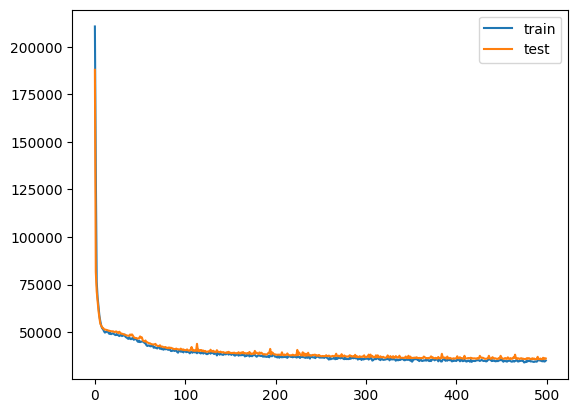

In [236]:
vector_size = X_train.shape[1]

model = NeuralNetwork(input_size=vector_size)
model.to(device)

train_and_evaluate(model, epochs=500, learning_rate=0.001)

In [238]:
def format_value(val: float) -> str:
    # If the value is an integer, format as an integer.
    if val.is_integer():
        return f"{int(val):,}".replace(",", " ")
    else:
        return f"{val:,}".replace(",", " ")

model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_test_device = y_test_tensor.to(device)
    predictions = model(X_test_device)

print("Example predictions vs. Ground Truth:")
for pred, true in zip(predictions[:5], y_test_device[:5]):
    pred_val = pred.item()
    true_val = true.item()
    print(f"Prediction: {format_value(pred_val):20}  |  Ground Truth: {format_value(true_val)}")

Example predictions vs. Ground Truth:
Prediction: 198 776.765625        |  Ground Truth: 141 592
Prediction: 89 147.6171875        |  Ground Truth: 51 327
Prediction: 88 121.546875         |  Ground Truth: 48 672
Prediction: 388 429.65625         |  Ground Truth: 380 530
Prediction: 121 790.7890625       |  Ground Truth: 78 318
